# Visualization of the data
## H3.6m dataset

The dataset contains 17 scenarios:

In [1]:
scenarios = ["walking", "eating", "smoking", "discussion", "directions",
                    "greeting", "phoning", "posing", "purchases", "sitting",
                    "sittingdown", "takingphoto", "waiting", "walkingdog",
                    "walkingtogether"]

The actions are performed by several subjects (human actors), each of them is identified by a number:

In [2]:
subs = [
    [1, 6, 7, 8, 9], # train
    [11], # validation
    [5] # test
]

The original dataset is captured at 50Hz (1 / 20ms). We will apply a downsampling factor of 2 -> 25Hz (1 / 40ms).
10 frames are used as seed frames, and the model is trained to predict the next 10 frames. (400ms seed, 400ms prediction)


## Joint xyz coordinate format

33 joints are tracked for each frame of the sequence. The joints are identified by a number:

In [3]:
joint_name_h3m = [
    "Hips", "RightUpLeg", "RightLeg", "RightFoot", "RightToeBase", "Site", "LeftUpLeg", "LeftLeg", "LeftFoot",
    "LeftToeBase", "Site", "Spine", "Spine1", "Neck", "Head", "Site", "LeftShoulder", "LeftArm", "LeftForeArm",
    "LeftHand", "LeftHandThumb", "Site", "L_Wrist_End", "Site", "RightShoulder", "RightArm", "RightForeArm",
    "RightHand", "RightHandThumb", "Site", "R_Wrist_End", "Site"
]

Several joints are constant or are at same position with other joints, and will be ignored:

In [4]:
import numpy as np

joint_to_ignore = np.array([0, 1, 6, 11, 16, 20, 23, 24, 28, 31])

print('joints to be ignored:', np.array(joint_name_h3m)[joint_to_ignore])
print('number of joints left:', len(joint_name_h3m) - len(joint_to_ignore))

joints to be ignored: ['Hips' 'RightUpLeg' 'LeftUpLeg' 'Spine' 'LeftShoulder' 'LeftHandThumb'
 'Site' 'RightShoulder' 'RightHandThumb' 'Site']
number of joints left: 22


The raw data is provided in the axis-angle format. The xyz coordinates are obtained by an exponential map, then the global rotation and translation are removed (local movement).

In [4]:
import sys
sys.path.append('/home/azhuavlev/PycharmProjects/MotionMixerConv')
from h36m.datasets import dataset_h36m, dataset_h36m_ang
%load_ext autoreload
%autoreload 2

dataset_xyz = dataset_h36m.H36M_Dataset(
    data_dir='/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses',
    input_n=100,
    output_n=100,
    skip_rate=2,
    split=0
)

processing action walking, time 1694860838.82
processing action eating, time 1694860855.16
processing action smoking, time 1694860855.45
processing action discussion, time 1694860855.76
processing action directions, time 1694860856.19
processing action greeting, time 1694860856.37
processing action phoning, time 1694860856.51
processing action posing, time 1694860856.79
processing action purchases, time 1694860856.92
processing action sitting, time 1694860857.06
processing action sittingdown, time 1694860857.42
processing action takingphoto, time 1694860857.74
processing action waiting, time 1694860857.87
processing action walkingdog, time 1694860858.06
processing action walkingtogether, time 1694860858.26
processing action walking, time 1694860858.41
processing action eating, time 1694860858.79
processing action smoking, time 1694860859.04
processing action discussion, time 1694860859.39
processing action directions, time 1694860859.68
processing action greeting, time 1694860859.99
pr

Example preprocessed batch, joint coordinates are im millimeters (mm):
_Important note_: h3.6m uses OpenCV coordinate system, which has different coordinate axes orientation:
Matplotlib: x right, y forward, z up
Opencv: x right, y down, z forward
To convert between them, we need to swap y and z axes, and negate y axis.
This does *not* affect the *training*, but is relevant for visualization.

In [6]:
batch = dataset_xyz[0][:, dataset_xyz.dimensions_to_use]

print(batch)
print('batch.shape', batch.shape)

[[ -71.22052  -419.46445   128.04242  ... -233.02156  -241.97878
    66.888115]
 [ -70.48413  -419.0326    129.09505  ... -236.51244  -242.83264
    67.11383 ]
 [ -69.48038  -418.509     130.29828  ... -239.31981  -242.51956
    69.43913 ]
 ...
 [-118.77522  -373.72687   237.24037  ... -275.61002  -238.96727
    23.281116]
 [-111.79299  -370.53876   241.67976  ... -271.5594   -236.72733
    39.22251 ]
 [ -98.78412  -369.84366   241.25525  ... -268.8989   -233.02702
    52.89633 ]]
batch.shape (200, 66)


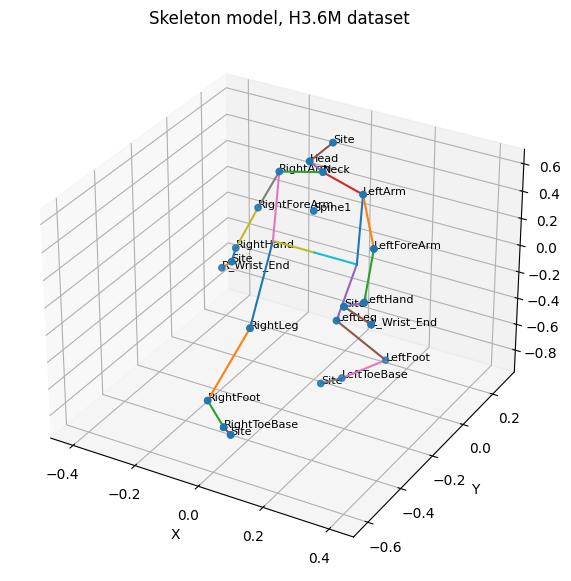

In [7]:
import conv_mixer.utils.visualization_helpers_h3m as visualization_helpers_h3m

visualization_helpers_h3m.visualize_batch_single_h3m(dataset_xyz[100])

![SegmentLocal](/home/azhuavlev/PycharmProjects/MotionMixerConv/conv_mixer/animation.gif "segment")

In [8]:
# Test gif generation, remove later

In [9]:
batch = dataset_xyz[100]

In [10]:
import numpy as np
# dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
#                     26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
#                     46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
#                     75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
# sequences_train = batch[0:25,
#                         dim_used].view(25, len(dim_used))

## Axis-angle format

The second possible format is axis-angle. Again, the global rotation and translation are removed (local movement), but we use less joints than in the xyz format. Train/validation/test splits and the number of sequences are the same.

In [11]:
dimensions_to_use_angle = np.array(
            [6, 7, 8, 9, 12, 13, 14, 15, 21, 22, 23, 24, 27, 28, 29, 30, 36, 37, 38, 39, 40, 41, 42,
             43, 44, 45, 46, 47, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 75, 76, 77, 78, 79, 80, 81, 84, 85, 86])
dimensions_to_ignore_angle = np.array(
            [0, 1, 2, 3, 4, 5, 10, 11, 16, 17, 18, 19, 20, 25, 26, 31, 32, 33, 34, 35, 48, 49, 50, 58,
              59, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 82, 83, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
              98])
print('number of joints to use:', len(dimensions_to_use_angle) // 3)
print('number of joints to ignore:', len(dimensions_to_ignore_angle) //3)

number of joints to use: 16
number of joints to ignore: 17


In [12]:
dataset_angle = dataset_h36m_ang.H36M_Dataset_Angle(
    data_dir='/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses',
    input_n=100,
    output_n=100,
    skip_rate=2,
    split=0
)

In [13]:
batch_angle = dataset_angle[0][:, dimensions_to_use_angle]

print(batch_angle)
print('batch_angle.shape', batch_angle.shape)

[[ 0.3230213 -0.4831149 -0.0673216 ...  0.1473034 -0.1267874 -0.0072563]
 [ 0.3259532 -0.4838686 -0.0682784 ...  0.1349617 -0.0768555  0.0021032]
 [ 0.3294488 -0.4855806 -0.0695968 ...  0.1272881 -0.0470906  0.0103329]
 ...
 [ 0.5543316 -0.6687866  0.1618684 ...  0.1438099  0.2838625 -0.0268883]
 [ 0.5716785 -0.6677975  0.1498878 ...  0.1313288  0.2131509  0.0040503]
 [ 0.5799299 -0.7250111  0.1374053 ...  0.1095381  0.1248537  0.0352608]]
batch_angle.shape (200, 48)


## Dataset captured in AIS lab

The dataset captures 27 keypoints, of which only 19 are used. The data is provided in both xyz and axis-angle formats.

In [14]:
joints_ais = [
    "Nose", "Neck", "RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow", "LWrist", "MidHip", "RHip", "RKnee",
    "RAnkle", "LHip", "LKnee", "LAnkle", "REye", "LEye", "REar", "LEar"
]
joints_ais_unused = [
    "Head", "Belly", "LBToe", "LSToe", "LHeel", "RBToe", "RSToe", "RHeel"
]

Input data format is JSON:

In [10]:
import os

# list only json files, without the extension
all_files = os.listdir("/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses")
json_files = [f[:-5] for f in all_files if f.endswith(".json")]
print(sorted(json_files))

['2021-08-04-singlePerson_000', '2021-08-04-singlePerson_001', '2021-08-04-singlePerson_002', '2021-08-04-singlePerson_003', '2022-05-26_2persons_000', '2022-05-26_2persons_001', '2022-05-26_2persons_002', '2022-05-26_2persons_003']


In [15]:
import json

in_file_name = "/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses/2021-08-04-singlePerson_000.json"
with open(in_file_name, 'r') as f:
    pose_data = json.load(f)
pose_data[0]['person']['keypoints'][0]

{'score': 3.3462276458740234,
 'pos': [-1.579332303842465, 5.254447240387596, 1.2453899554859404],
 'cov': [0.00028858751417853756,
  -0.00014108748570844474,
  9.386520816399225e-06,
  0.0012445461087687588,
  -0.0002077309460947308,
  0.00025123770636866134]}

Some joints have score of 0, they need to be ignored

In [16]:
pose_data[0]['person']['keypoints'][-1]

{'score': 0.0, 'pos': [0.0, 0.0, 0.0], 'cov': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

## Raw dataset

In [16]:
import conv_mixer.datasets.dataset_ais_xyz as dataset_ais_xyz
dataset_ais_raw = dataset_ais_xyz.DatasetAISxyz(
    data_dir="/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses",
    input_n=100,
    output_n=100,
    skip_rate=1,
    actions=[
        "2022-05-26_2persons_003",
    ],
    smoothing_alpha=0.99
)

*********************************
Reading action 2022-05-26_2persons_003
Failed to process frame 1213 in action 2022-05-26_2persons_003: Keypoint 0 has score 0
Total n of frames 1744
Failed to process 1 frames
indices of failed frames: 1213, 
Current n of sequences: 1344


/scratch_net/manifoldnet/azhuavlev/conda_envs/neuman_kaolin/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/scratch_net/manifoldnet/azhuavlev/conda_envs/neuman_kaolin/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when crea

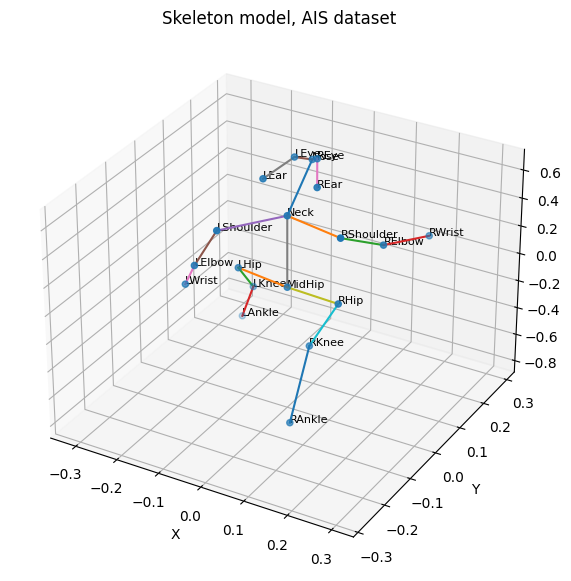

In [17]:
import conv_mixer.utils.visualization_helpers_ais
conv_mixer.utils.visualization_helpers_ais.visualize_batch_single_ais(dataset_ais_raw[510])

In [8]:
# import conv_mixer.visualization_helpers
conv_mixer.utils.visualization_helpers_ais.make_animation_ais(dataset_ais_raw[510], add_title=True, add_joint_names=True,
                                                          save_name='animation_ais_1')

![SegmentLocal](/home/azhuavlev/PycharmProjects/MotionMixerConv/conv_mixer/animation_ais_1.gif "segment")

## Smoothing with alpha=0.15

In [13]:
import conv_mixer.datasets.dataset_ais_xyz as dataset_ais_xyz
dataset_ais = dataset_ais_xyz.DatasetAISxyz(
    data_dir="/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses",
    input_n=100,
    output_n=100,
    skip_rate=1,
    actions=[
        "2022-05-26_2persons_003",
    ],
    smoothing_alpha=0.15
)

*********************************
Reading action 2022-05-26_2persons_003
Failed to process frame 1213 in action 2022-05-26_2persons_003: Keypoint 0 has score 0
Total n of frames 1744
Failed to process 1 frames
indices of failed frames: 1213, 
Current n of sequences: 1344


In [11]:
# import conv_mixer.visualization_helpers
conv_mixer.utils.visualization_helpers_ais.make_animation_ais(dataset_ais[510], add_title=True, add_joint_names=True,
                                                          save_name='animation_ais_015')

/scratch_net/manifoldnet/azhuavlev/conda_envs/neuman_kaolin/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/scratch_net/manifoldnet/azhuavlev/conda_envs/neuman_kaolin/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when crea

![SegmentLocal](/home/azhuavlev/PycharmProjects/MotionMixerConv/conv_mixer/animation_ais_015.gif "segment")

In [12]:
print(dataset_ais[510].shape)

torch.Size([200, 57])
